In [86]:
# Handle SSH error
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context



In [87]:
#@title
import os
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support and len(model.support_vectors_<1):
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='black',alpha=0.3);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def plot_decision_regions_svm(X, y, classifier, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #plot_svc_decision_boundary(classifier,x1_min,x1_max)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plot_svc_decision_function(classifier)
    

## Impact de la standardisation des données

Le code fournit une petit dataset de 4 obsvervations.

1. Entrainez un SVM linéaire sur et représentez les résultats dans un graphique avec la fonction plot_decision_region_svm(X,y,classifieur)
2. Générez une version standardisée du même jeu de données (à la main)
répétez la question 1 sur le le nouveau jeu de données. Concluez.

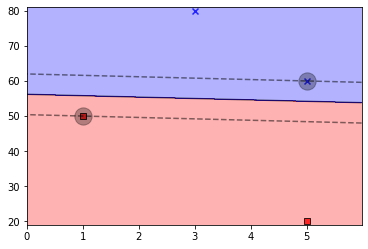

In [88]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

clf = SVC(kernel='linear')
clf.fit(Xs,ys)

plot_decision_regions_svm(Xs,ys,clf)



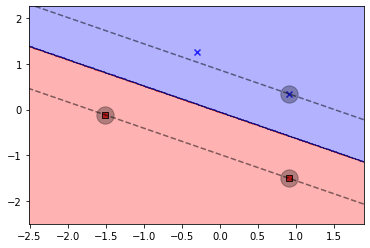

In [89]:
Xn= Xs.copy()
Xn[:,0] = (Xs[:,0]-np.mean(Xs[:,0]))/np.std(Xs[:,0])
Xn[:,1] = (Xs[:,1]-np.mean(Xs[:,1]))/np.std(Xs[:,1])


clf.fit(Xn,ys)

plot_decision_regions_svm(Xn,ys,clf)



## Impact du paramètre C sur le classifieur
On reprend l'exemple de la base Iris, cas non séparable.
1- Créez une fonction qui sépare alétoirement le jeu de données en deux sous ensembles, dits 'TRAIN' (80% du dataset) et 'TEST'(20% du dataset). Note: on aura donc en sortie de la fonction X_train,Y_train,X_test et X_test

1- Entrainez un classifieur avec linéaire avec C=1, C=50, et C=200, et comparez leur accuracies et affichez le frontières de décisions et vecteurs supports. Que constatez-vous?

2- Recherche du C optimal: on donne un liste de valeurs pour C à évaluer. En répétant l'opération 50 fois: 

    -Séparer alétoirement le dataset en deux ensembles TRAIN et TEST

    -Evaluez l'accuracy du classifieur pour toutes les valeurs de C

Affichez un plot, qui donne l'accuracy moyenne sur les 50 essais pour chaque valeur de C. Concluez.

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


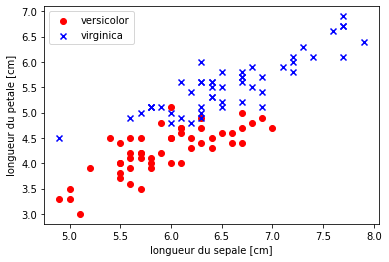

In [90]:
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)

df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')

# selectionn de setosa et versicolor
y = df.iloc[50:150, 4].values

# precedemment, on s'interessait à deux autres classes
#y = np.where(y == 'Iris-setosa', -1, 1)
y = np.where(y == 'Iris-versicolor', -1, 1)

# extraction de la longueur du sepale length et de la longueur du petale
X = df.iloc[50:150, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='versicolor')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='virginica')

plt.xlabel('longueur du sepale [cm]')
plt.ylabel('longueur du petale [cm]')
plt.legend(loc='upper left')

plt.show()

In [91]:
from sklearn.model_selection import train_test_split

def separateur(X,y):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
  return X_train,y_train,X_test,y_test

def accuracy(classif,X,y,X_test=None,y_test=None):
  classif.fit(X,y)
  if X_test is None:
    y_pred= classif.predict(X)
    return(np.sum(y==y_pred)/y.shape[0])
  else:
    y_pred= classif.predict(X_test)
    return(np.sum(y_test==y_pred)/y_test.shape[0])


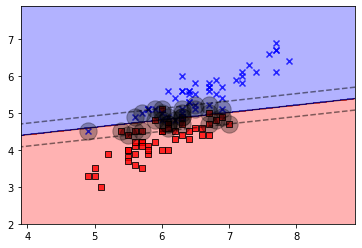

In [92]:
c1 = SVC(kernel='linear', C=1)
c1.fit(X,y)
plot_decision_regions_svm(X,y,c1)

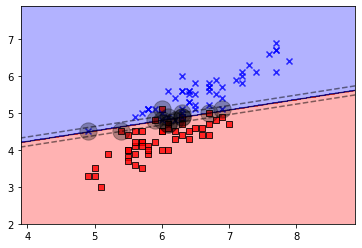

In [93]:
c2 = SVC(kernel='linear', C=50)
c2.fit(X,y)
plot_decision_regions_svm(X,y,c2)

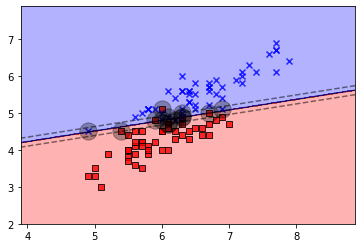

In [94]:
c3 = SVC(kernel='linear', C=200)
c3.fit(X,y)
plot_decision_regions_svm(X,y,c3)

In [95]:
X_tr,y_tr,X_tst,y_tst = separateur(X,y)

print(f'Before :\n {len(X)}')
print(f'After :\n {len(X_tr)}')

Before :
 100
After :
 80


[0.943 0.943 0.94  0.942 0.941 0.943 0.945 0.943 0.942 0.941 0.94  0.94
 0.94  0.941 0.94  0.941 0.939]


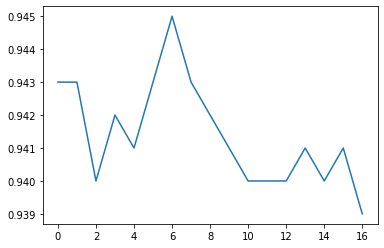

In [96]:
Cs=[1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,200,500]
Clfs = [SVC(kernel='linear',C=c) for c in Cs]

n_xp = 50
accs = np.zeros((len(Cs),n_xp))
for i in range(n_xp):
  X_tr,y_tr,X_tst,y_tst = separateur(X,y)
  for j in range(len(Clfs)):
    accs[j,i] = accuracy(Clfs[j],X_tr,y_tr,X_tst,y_tst) 

avg_accs = np.mean(accs,axis=1)
print(f'{avg_accs}')

plt.plot(np.arange(len(Cs)),avg_accs)


## Méthodes à Noyaux, Cas quadratique

On reprend l'exemple de dataset généré par la fonction Circles.

1- Entrainez un SVM avec noyaux polynomial de degré 2 et affichez la frontière de décision.

2- Implémenter (efficacement) une fonction *my_kernel(x, y):* prenant en entrée deux np.array de taille respectives $(1 \times k)$ et $(1 \times k)$ et qui retourne la distance entre $x$ et $y$ correspondant à un noyau quadratique: 

  *   $k_{quad} (x,y) = (x^\top y)^2$

2bis - Implémenter (efficacement) une fonction *my_gram(X, Y):* prenant en entrée deux np.array de taille respectives $(n \times k)$ et $(m \times k)$ et qui retourne la matrice de Gram $K$ (de taille $n\times m$) d'un noyau polynomial de degree 2.


3- Entrainer un SVM en utilisant la Matrice de Gram resultant de la fonction my_gram d'une part, et utilisant la fonction my_kernel d'autre part, et retournez les indices des vecteurs supports.



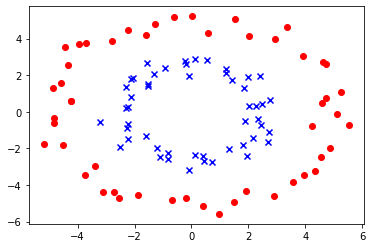

In [97]:
from sklearn.datasets import make_circles

X,y=make_circles(noise=0.07,factor=0.5)
X=X*5

plt.clf()
plt.scatter(X[y==0][:,0],X[y==0][:,1],color='red', marker='o')
plt.scatter(X[y==1][:,0],X[y==1][:,1],color='blue',marker='x')
plt.show()



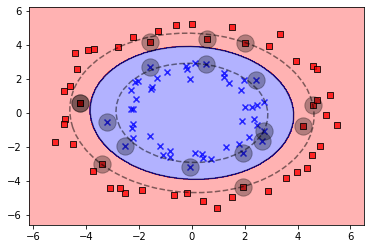

In [98]:
clf = SVC(kernel='poly',degree=2)
clf.fit(X,y)

plot_decision_regions_svm(X,y,clf)


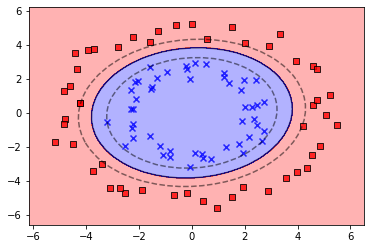

In [99]:
def my_kernel(X,Y):
    return (np.dot(X,Y.T)**2)


clf = SVC(kernel=my_kernel)
clf.fit(X,y)
plot_decision_regions_svm(X,y,clf)


In [100]:
def my_gram(X,Y):
    return X,Y

my_gram(X,y)
 


9